# Locate peak on 2-D area detector image

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

TODO:

## Start the `instrument` package

In [1]:
from instrument.collection import *

Activating auto-logging. Current session state plus future input saved.
Filename       : /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Thu-21:54:42 - #### Bluesky Framework ####
I Thu-21:54:42 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_python.py
I Thu-21:54:42 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_bluesky.py
I Thu-21:54:42 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/initialize.py
I Thu-21:54:43 - using databroker catalog 'class_2021_03'
I Thu-21:54:43 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/metadata.py
I Thu-21:54:43 - #### Devices ####
I Thu-21:54:43 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/devices/area_detector.py
I Thu-21:54:43 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/devices/calculation_records.py
I Thu-21:54:46 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/devices

Rebuild the area detector object: `adsimdet`

In [2]:
from ophyd import SimDetector
from ophyd import ADComponent
from ophyd import SingleTrigger
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34

class MyHdf5Plugin(FileStoreHDF5IterativeWrite, HDF5Plugin_V34):
    pass

IOC_PATH = "/tmp/images"
DOCKER_MOUNT = "/tmp/docker_ioc/iocad"

class MyDetector(SingleTrigger, SimDetector):
    hdf1 = ADComponent(
        MyHdf5Plugin,
        suffix='HDF1:',
        write_path_template=IOC_PATH,
        read_path_template=f"{DOCKER_MOUNT}{IOC_PATH}",
    )


adsimdet = MyDetector("ad:", name="adsimdet")
adsimdet.wait_for_connection(timeout=15)
adsimdet.hdf1.create_directory.put(-5)

adsimdet.read_attrs.append("hdf1")

adsimdet.cam.stage_sigs["image_mode"] = "Single"
adsimdet.cam.stage_sigs["num_images"] = 1
adsimdet.cam.stage_sigs["acquire_time"] = 0.1
adsimdet.cam.stage_sigs["acquire_period"] = 0.105
adsimdet.hdf1.stage_sigs["lazy_open"] = 1
adsimdet.hdf1.stage_sigs["compression"] = "None"

Count the detector : record an image.

In [3]:
RE(bp.count([adsimdet], md={"motive": "locate_image_peak"}))



Transient Scan ID: 296     Time: 2021-02-25 21:54:49
Persistent Unique Scan ID: 'fc3b9b4c-3993-421d-8c0a-68539ebe91f1'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 21:54:49.7 |
+-----------+------------+
generator count ['fc3b9b4c'] (scan num: 296)


('fc3b9b4c-3993-421d-8c0a-68539ebe91f1',)

## View the image

Since area detector images are typically quite large, they are never 
read into Python memory during data acquisition.  To view the image 
here, we need to use the *databroker* which reads the run data.  The 
run data includes the reference to the file that contains the image.

### Get the run
First, get the most recent run from `db`.

In [4]:
run = db.v2[-1]

Look at the run's metadata.  Confirm it has the `{"motive": "locate_image_peak"}` metadata we added.  That was stored in the `start` document.

In [5]:
print(run.metadata["start"]["motive"])

locate_image_peak


### Primary stream
The image was collected in the primary data stream.  Get the primary stream data from the database.

In [6]:
primary_data = run.primary.read()
primary_data

<xarray.Dataset>
Dimensions:         (dim_0: 1, dim_1: 1024, dim_2: 1024, time: 1)
Coordinates:
  * time            (time) float64 1.614e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    adsimdet_image  (time, dim_0, dim_1, dim_2) uint8 3 3 5 3 4 4 ... 3 3 5 3 3

### Get the image data

Get the named image `adsimdet_image` from the primary stream.

In [7]:
image = primary_data["adsimdet_image"]
image

<xarray.DataArray 'adsimdet_image' (time: 1, dim_0: 1, dim_1: 1024, dim_2: 1024)>
array([[[[3, 3, 5, ..., 5, 3, 3],
         [4, 4, 5, ..., 4, 4, 4],
         [4, 5, 3, ..., 4, 4, 3],
         ...,
         [3, 4, 4, ..., 4, 4, 3],
         [3, 4, 4, ..., 4, 3, 3],
         [3, 4, 3, ..., 5, 3, 3]]]], dtype=uint8)
Coordinates:
  * time     (time) float64 1.614e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Attributes:
    object:   adsimdet

### Image frame
This image object has rank of 4.  We just want the image frame (the last two indices).  Select the first item of each of the first two indices (time, frame number).

In [8]:
frame = image[0][0]
frame

<xarray.DataArray 'adsimdet_image' (dim_1: 1024, dim_2: 1024)>
array([[3, 3, 5, ..., 5, 3, 3],
       [4, 4, 5, ..., 4, 4, 4],
       [4, 5, 3, ..., 4, 4, 3],
       ...,
       [3, 4, 4, ..., 4, 4, 3],
       [3, 4, 4, ..., 4, 3, 3],
       [3, 4, 3, ..., 5, 3, 3]], dtype=uint8)
Coordinates:
    time     float64 1.614e+09
Dimensions without coordinates: dim_1, dim_2
Attributes:
    object:   adsimdet

### Show the image

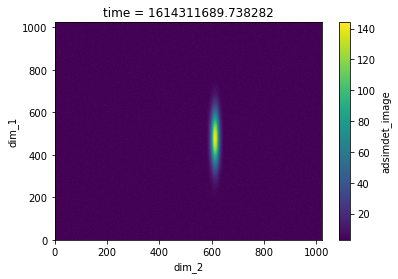

In [9]:
frame.plot.pcolormesh()

### Center & size of spot
Determine the center and width of this spot in both directions.

In [10]:
# TODO: